In [2]:
import pandas as pd
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

from isochrones import get_ichrone, SingleStarModel

Holoviews not imported. Some visualizations will not be available.


In [3]:
df = pd.read_csv('hot_star.csv', dtype={'kic': str})

In [4]:
df

,Unnamed: 0,Unnamed: 0.1,kic,dSct,gdor,Teffi,e_Teffi,loggi,e_loggi,FeHi,...,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID
0,0,0,1026294,True,False,7887,80,3.901,0.15,-0.069,...,NaN,0.651858,0.691637,291.106337,36.792255,0.019246,0.022411,1.0,0,280724301
1,1,1,1161908,False,True,6173,80,4.175,0.15,-0.030,...,NaN,0.393840,0.421846,291.168667,36.820718,0.010929,0.013137,1.0,0,280724249
2,2,2,1162150,True,False,7087,248,3.465,0.40,-0.008,...,NaN,60.000000,60.000000,291.223975,36.887123,60.000000,60.000000,1.0,0,281660004
3,3,3,1163943,True,False,7202,222,4.104,0.40,-0.228,...,NaN,0.760697,0.788974,291.617656,36.885699,0.022835,0.028469,1.0,0,285287933
4,4,4,1294670,True,False,7299,255,4.050,0.40,-0.043,...,NaN,0.678202,0.786021,291.402037,36.971291,0.019562,0.023878,1.0,0,283490645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,3093,3438,9716350,False,True,6754,236,4.188,0.40,0.000,...,NaN,0.480421,0.606360,294.324900,46.462535,0.013020,0.020699,1.0,0,312790242
3094,3094,3439,11571757,False,True,6743,211,3.278,0.20,-0.300,...,NaN,0.697121,0.677965,297.474053,49.519844,0.019177,0.023709,1.0,0,344907947
3095,3095,3442,11809145,False,True,7121,196,3.713,0.20,-0.337,...,NaN,32.523830,29.479638,289.120120,50.044772,1.208301,1.321564,1.0,-1,265028280
3096,3096,3443,7746984,False,True,5584,195,3.290,0.20,-0.069,...,NaN,1068.000000,1068.000000,289.688083,43.400461,1068.000000,1068.000000,-1.0,0,269049231


In [7]:
from astroquery.mast import Observations, Catalogs



query = Observations.query_criteria(target_name=df['ID'].tolist(), 
                                    project='TESS', 
                                    dataproduct_type="TIMESERIES", 
                                    obs_collection='TESS')

In [10]:
query = query.to_pandas()

In [17]:
tess_obs = np.unique(query.target_name)
tess_obs

array(['120315082', '120962639', '121083955', '121122016', '121124576',
       '121546698', '121729614', '122138364', '122142317', '122375672',
       '122452155', '122681634', '122683109', '123231021', '123357376',
       '137098539', '137341551', '137488317', '137762597', '139154971',
       '158271090', '158494804', '158555987', '159050655', '159580386',
       '159647185', '159719806', '164415564', '164530781', '164647385',
       '164726308', '164832047', '171095675', '184010547', '185057693',
       '239227408', '239233211', '239272632', '239276223', '239306767',
       '243272097', '26418690', '26541086', '26749633', '26749728',
       '267669501', '267991311', '268299560', '269267602', '26961610',
       '270617514', '270619211', '270788955', '270789855', '271253876',
       '271352011', '271671189', '272599738', '272941454', '273036521',
       '273038338', '273777265', '27389070', '274120769', '27639466',
       '27645337', '27846645', '298897115', '351055073', '351193224',
 

In [20]:
len(tess_obs)

79

In [21]:
df[df.ID.isin(tess_obs)].to_csv('tic_AF.csv')

In [64]:
def create_param_list(row):
    params = {}
    
    # Plug in magnitudes
    band_key = [
#         'Gaia_BP_DR2Rev', 'Gaia_RP_DR2Rev', 
#                 'Bessell_B', 'Bessell_V', 
                'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z', 
#                 'J', 'H', 'K',
#                'WISE_W1', 'WISE_W2', 'WISE_W3', 'WISE_W4', 
#         'Gaia_G_DR2Rev'
               ]
    bands = [
#         'gaiabp','gaiarp',
#              'Bmag','Vmag',
             'umag','gmag','rmag','imag','zmag',
#              'Jmag','Hmag','Kmag',
#             'w1mag','w2mag','w3mag','w4mag',
#         'GAIAmag'
    ]
    avail_passbands = []
    for band, key in zip(bands, band_key):
        if not np.isnan(row[band]) and not np.isnan(row[f"e_{band}"]):
            params.update({
                 key: (row[band], row[f"e_{band}"])
            })
            avail_passbands.append(key)
            
    # Time for some fundamental parameters. yeah baby!
    fund = ['Teffi', 'loggi', 'FeHi', 'plx']
    keys = ['Teff', 'logg', 'feh', 'parallax']
    
    for f, key in zip(fund, keys):
        if not np.isnan(row[f]) and not np.isnan(row[f"e_{f}"]):
            params.update({
                key: (row[f], row[f"e_{f}"])
            })
            
    return params, avail_passbands

In [65]:
def fit_isochrone(iloc):
    row = df.iloc[iloc]
    params, pb = create_param_list(row)
    mist = get_ichrone('mist', bands=pb)
    mod = SingleStarModel(mist, **params)
    mod.fit(basename=f'/home/daniel/chains/{row.kic}/')
    
    mod.corner_observed();
    plt.show()
#     plt.savefig(f'/home/daniel/chains/{row.kic}_corner_observed.png', dpi=150)
#     plt.clf()
#     plt.close('all')
    
    mod.corner_physical();
    plt.show()
#     plt.savefig(f'/home/daniel/chains/{row.kic}_corner_physical.png', dpi=150)
#     plt.clf()
#     plt.close('all')
    
    lower, med, upper = np.percentile(mod.derived_samples, [15.86, 50, 84.13], axis=0)
    return mod

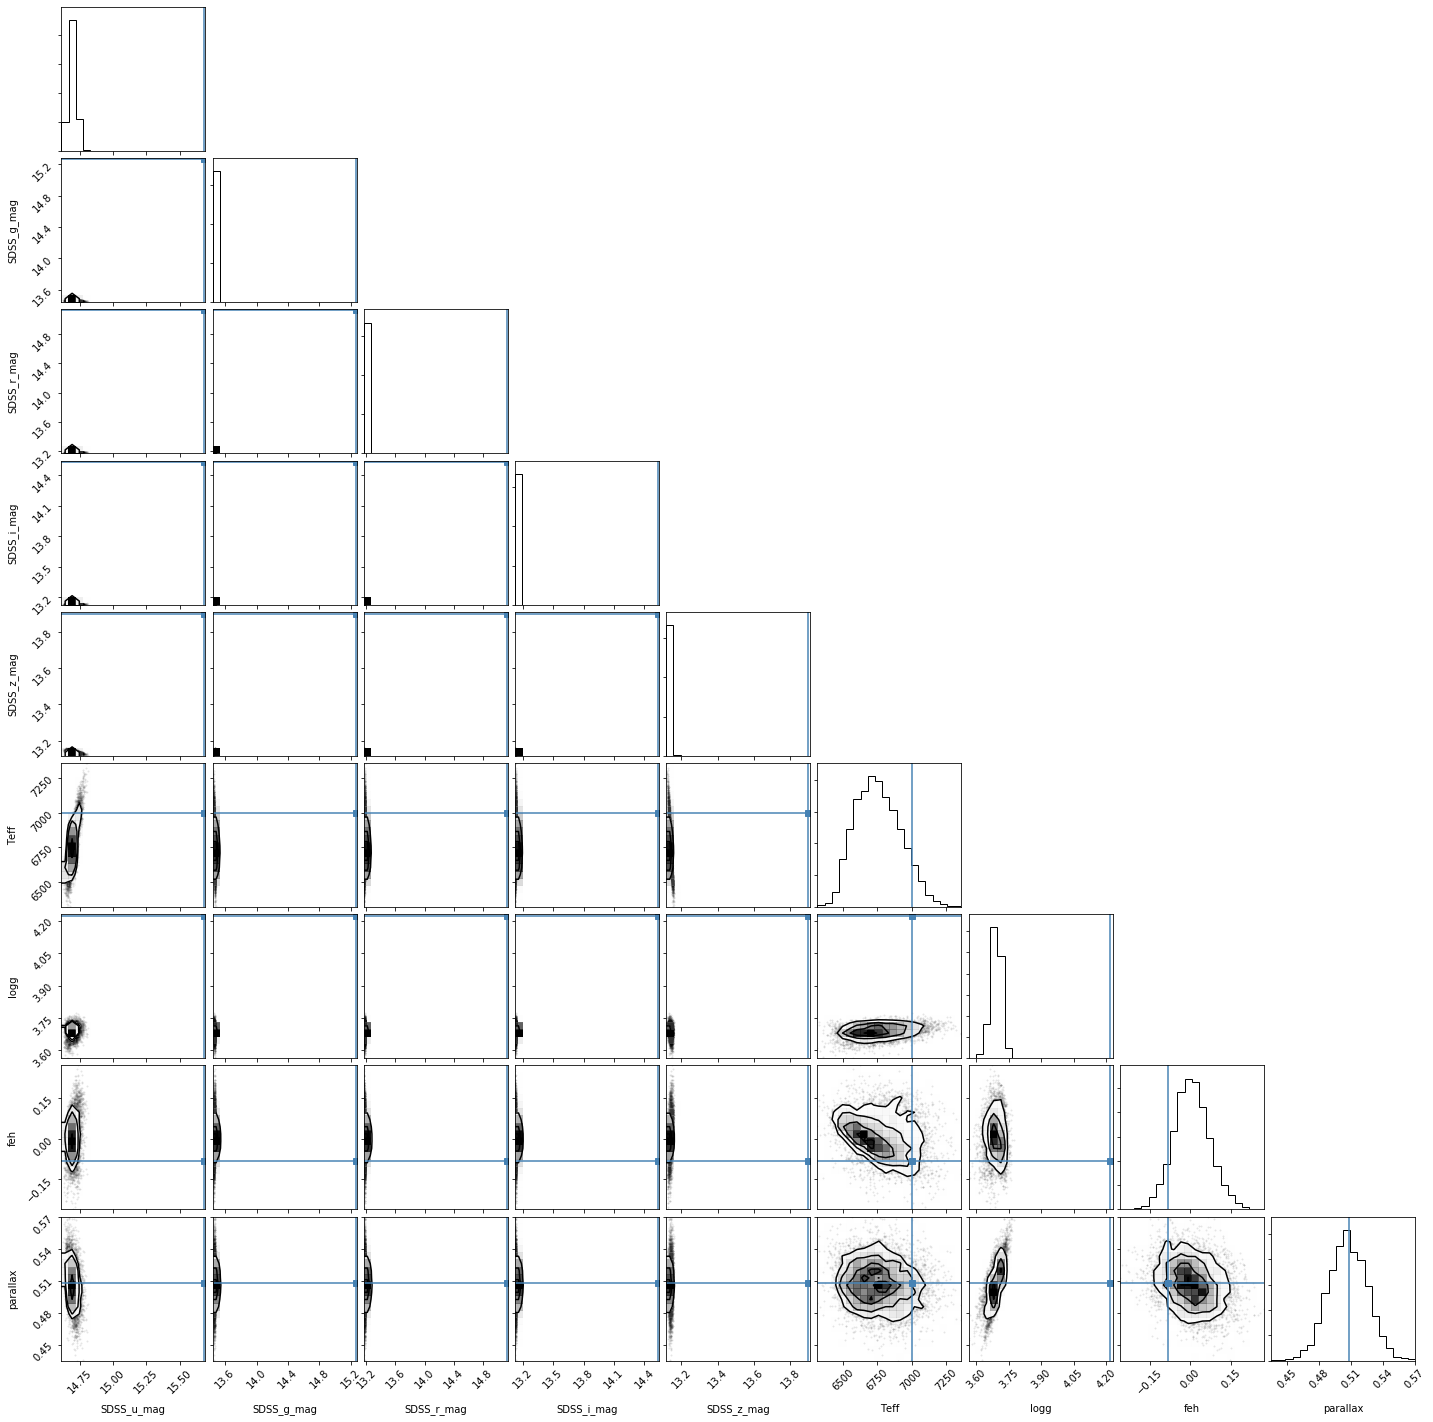

In [68]:
m.corner_observed();
plt.savefig('wtf.png', dpi=300, bbox_inches='tight')

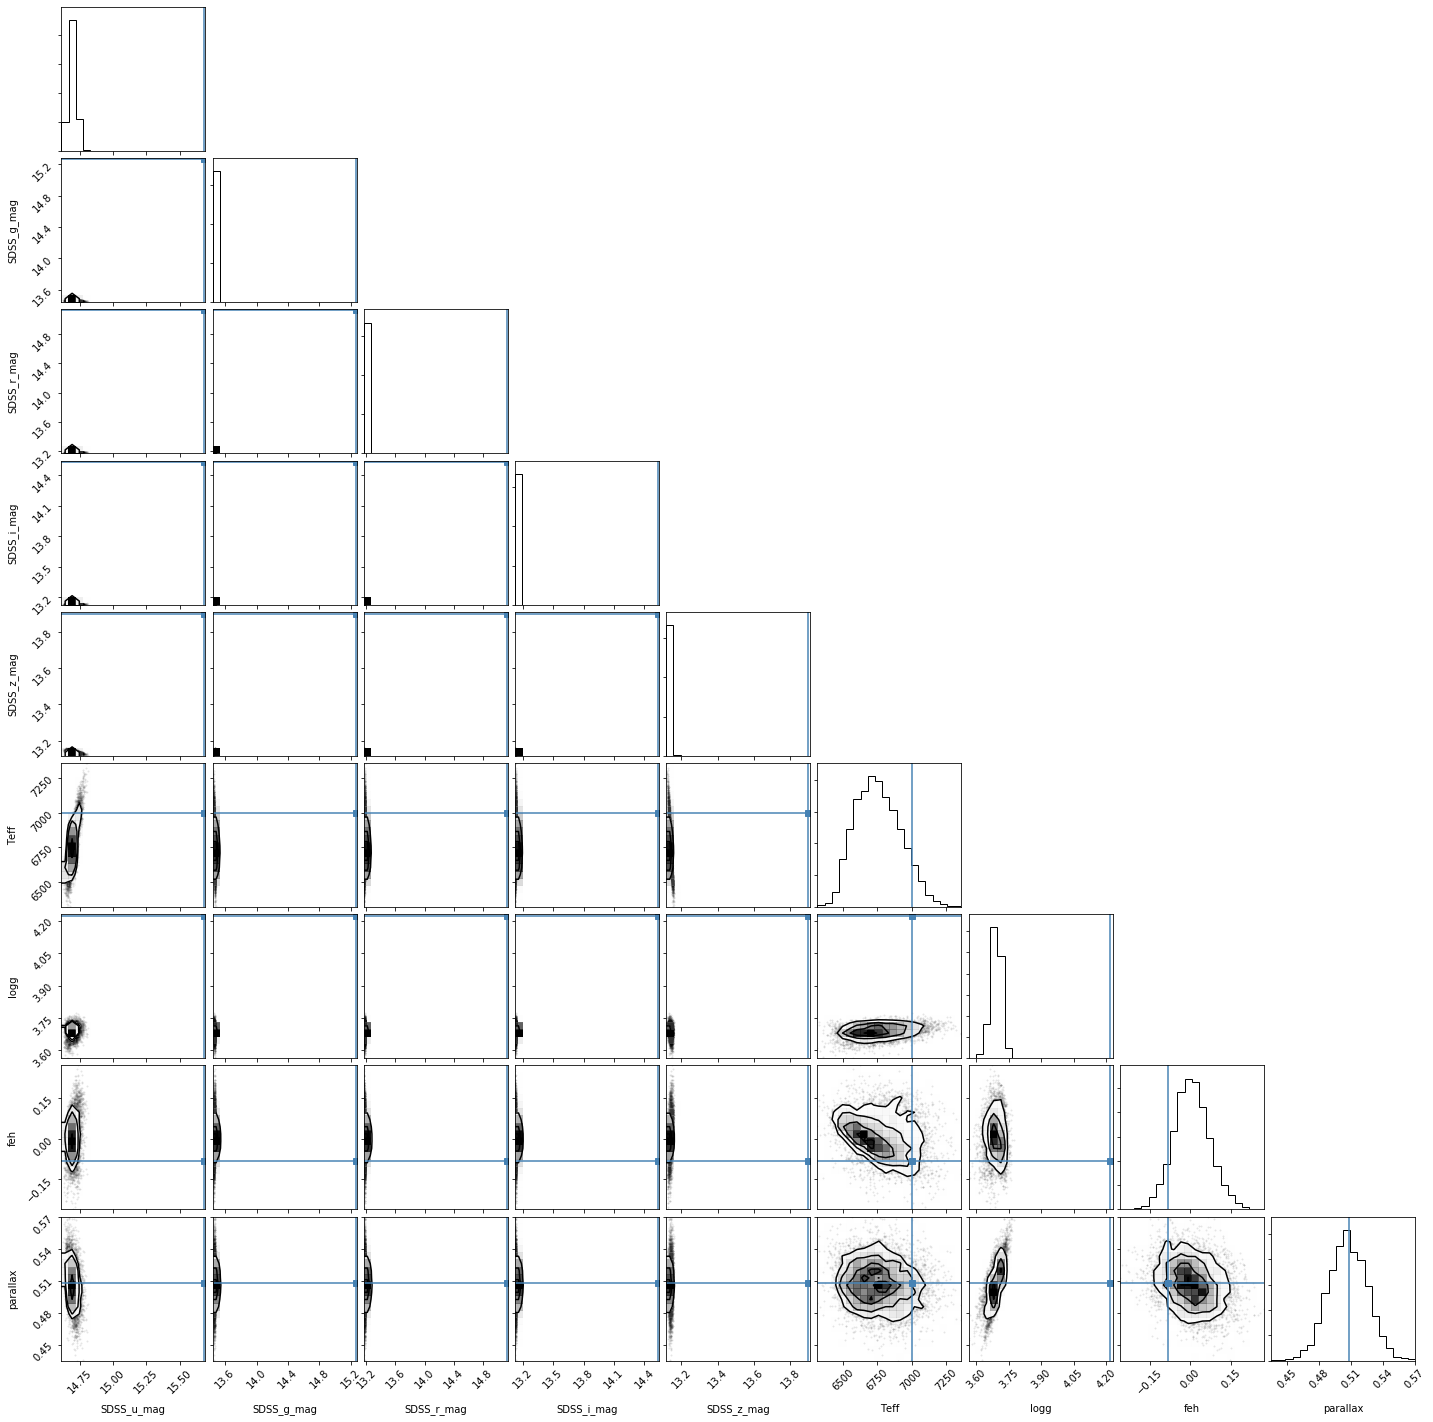

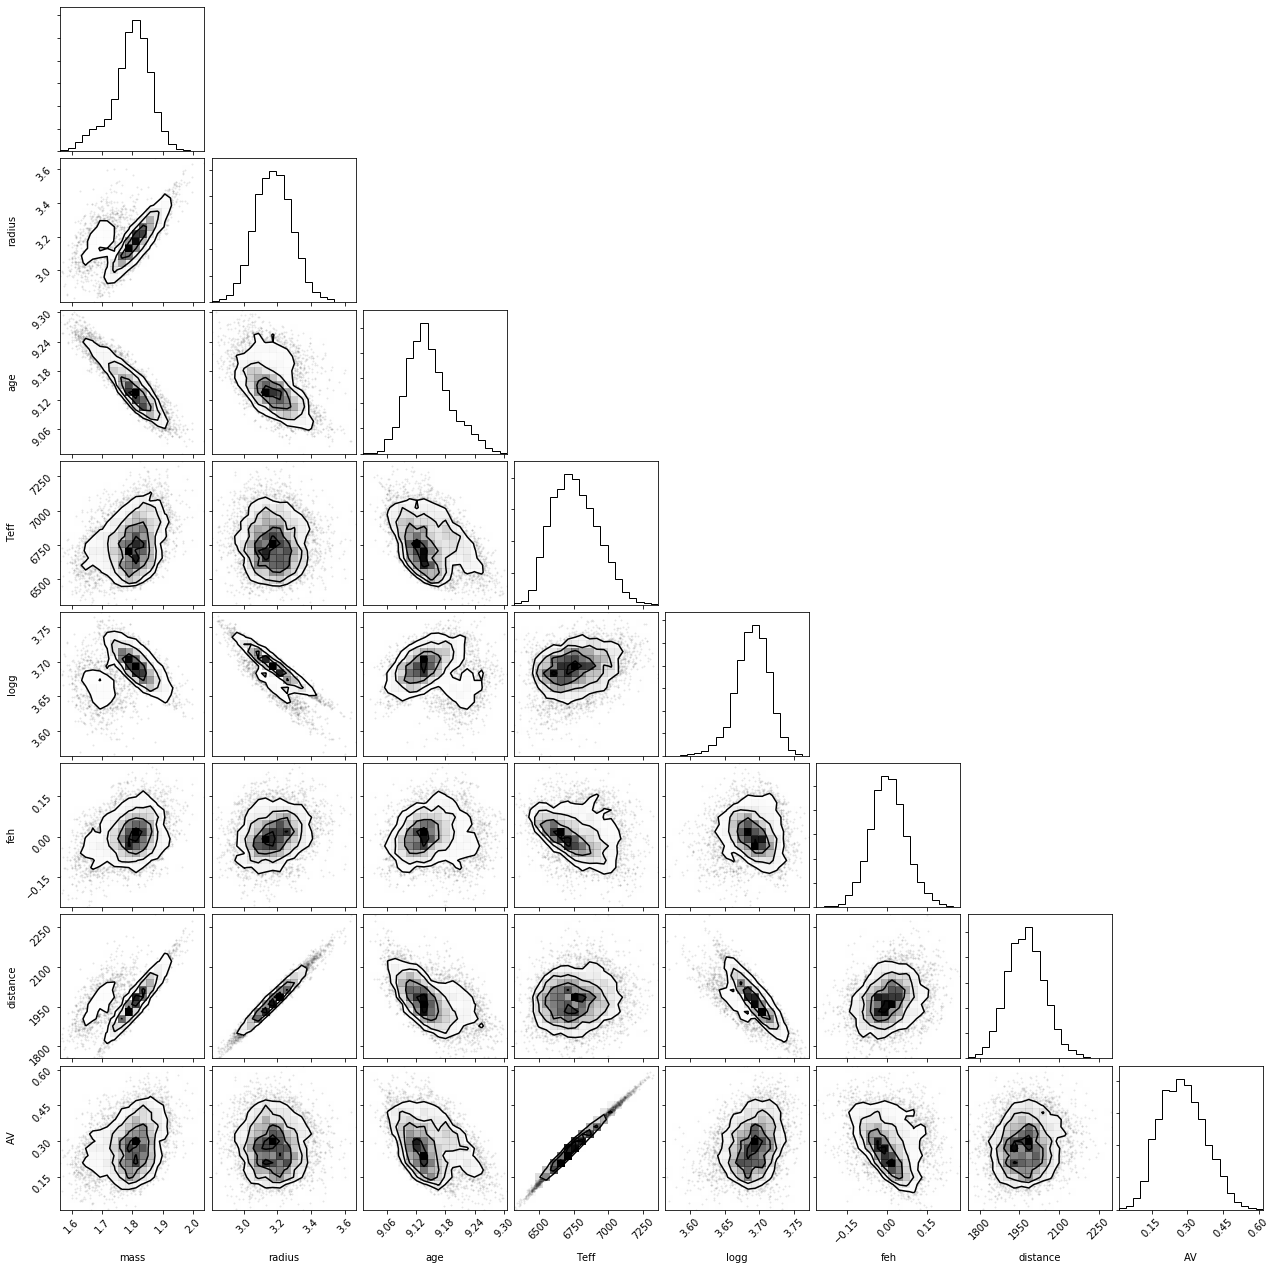

In [66]:
m = fit_isochrone(100)

In [19]:
row = df.iloc[1886]
row

Unnamed: 0           1886
Unnamed: 0.1         2080
kic               9651065
dSct                 True
gdor                 True
                  ...    
e_RA_orig       0.0401149
e_Dec_orig      0.0438607
raddflag                1
wdflag                  0
objID           294717361
Name: 1886, Length: 136, dtype: object

In [20]:
params, pb = create_param_list(row)
mist = get_ichrone('mist', bands=pb)
mod = SingleStarModel(mist, **params)
mod.fit(basename=f'/home/daniel/chains/{row.kic}_single/')

In [21]:
from isochrones import BinaryStarModel
mod2 = BinaryStarModel(mist, **params)
mod2.fit(basename=f'/home/daniel/chains/{row.kic}_double/')

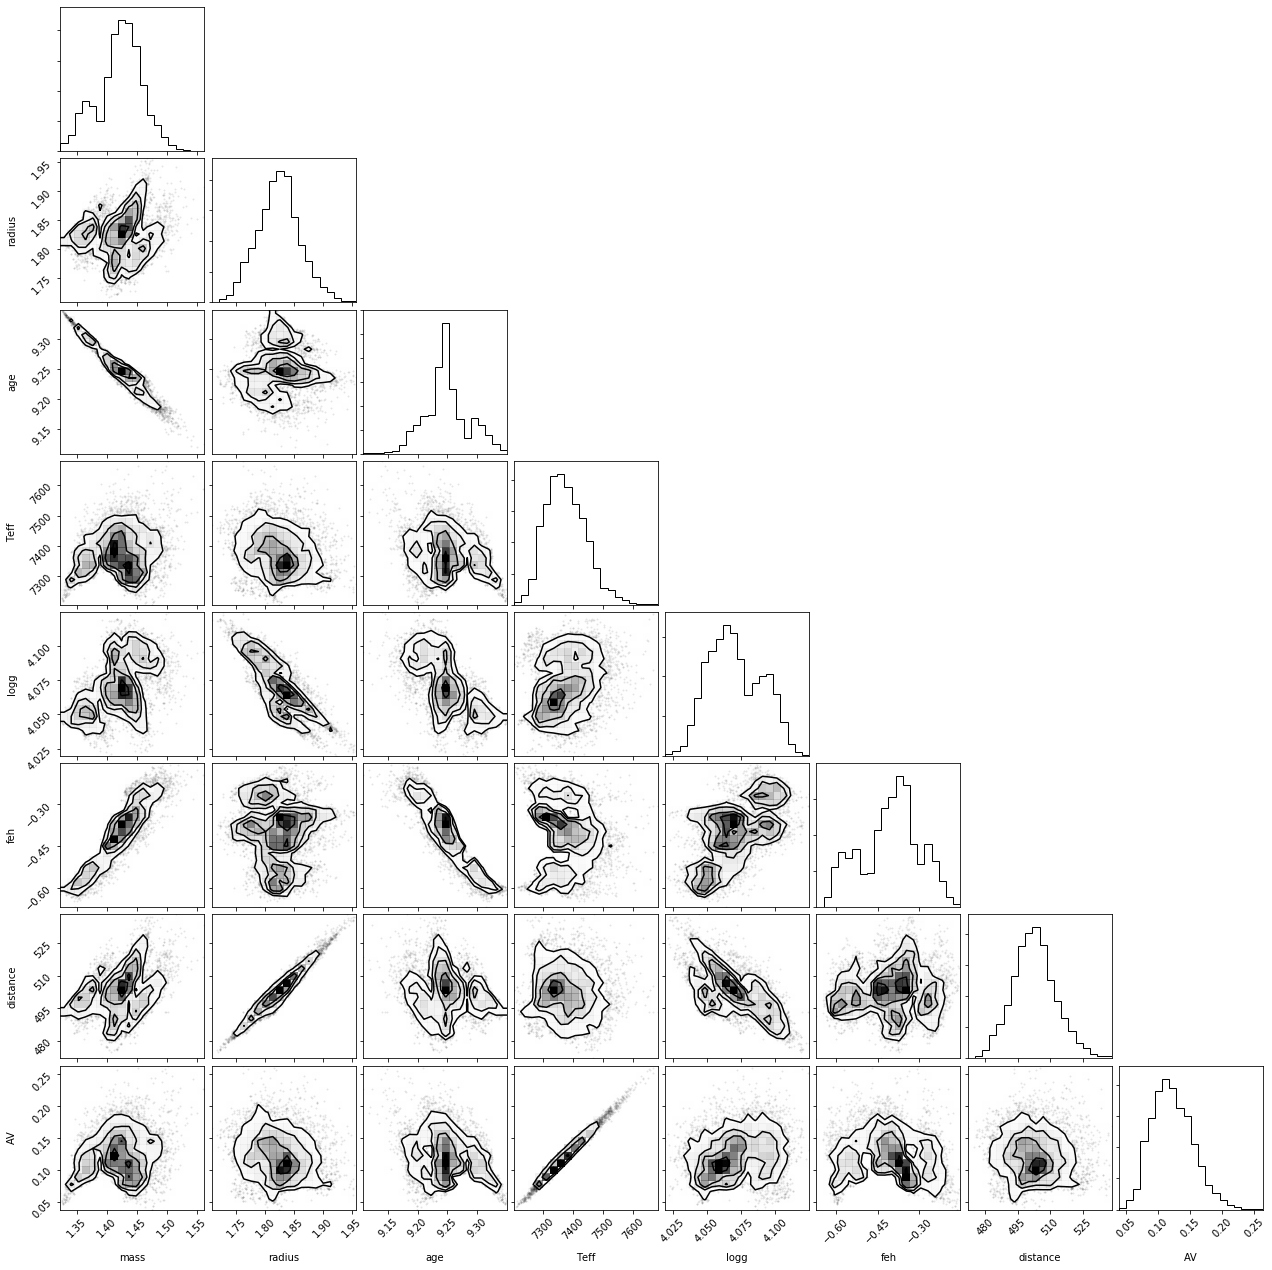

In [24]:
mod.corner_physical();

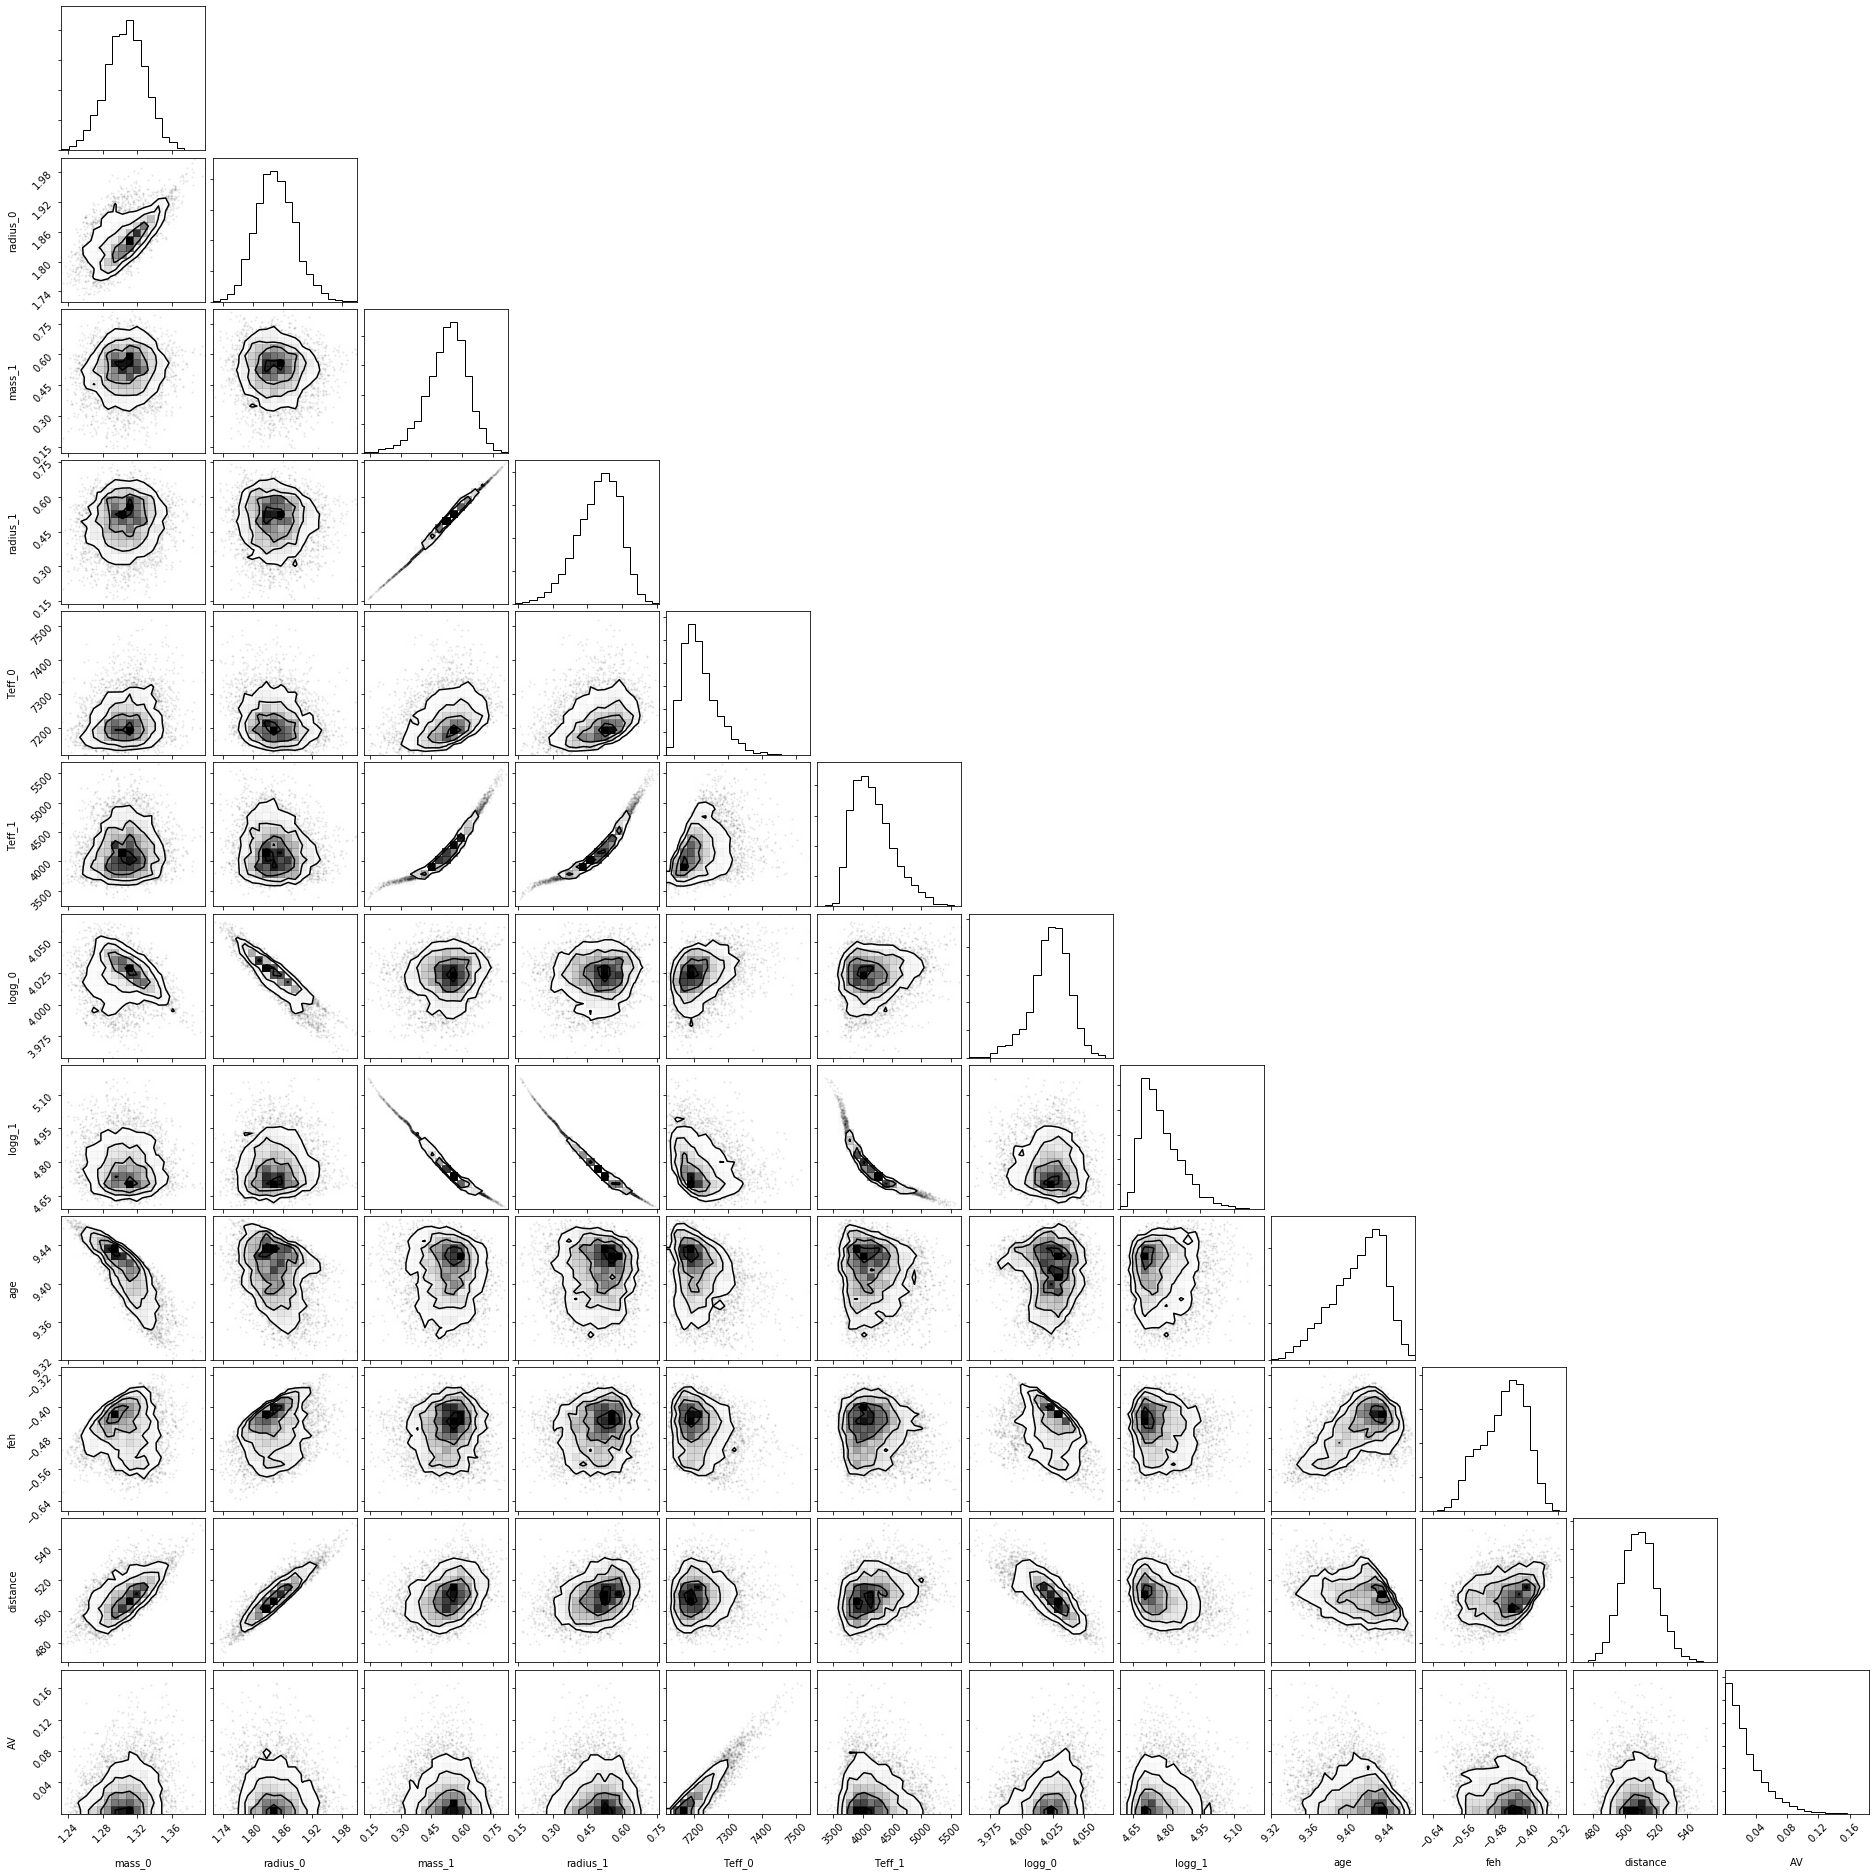

In [23]:
mod2.corner_physical();

In [54]:
mod.evidence[0] / mod2.evidence[0]

  analysing data from /home/daniel/chains/9651065_single/.txt
  analysing data from /home/daniel/chains/9651065_double/.txt


0.9659798646786717